# ДЗ №3 по Основам программирования на Python 

### Анализ результативности агентов в игре "Камень, ножницы, бумага"
#### Цель: Используя библиотеку kaggle-environments, которая реализует функционал взаимодействия между виртуальными агентами в рамках нескольких популярных игр, реализовать самостоятельно несколько агентов и сравнить их в игре «камень-ножницы-бумага»

Задачи: 
    
    1. Описать поведение бота, который будет играть с такими же ботами в игру «камень-ножницы-бумага». Поведение бота описывается с помощью функции, которая принимает на вход информацию о прошлых играх. Сигнатура функции приведена в Google Colab, а детальное описание входящих значений доступно по ссылке.
    2. После описания поведения агентов запустить турнир между ними и проверить, какая стратегия показывает себя лучше всех.

### Описание агентов, загрузка библиоте к ифункций
    
    1. RockAgent - всегда играет "камень"- (0).
    2. PaperAgent - всегда играет "бумага" - (1).
    3. ScissorsAgent - всегда играет "ножницы" - (2).
    4. RandomAgent - всегда делает случайный выбор.
    5. CycleAgent - последовательно чередует выбор: 0, 1, 2.
    6. MirrorAgent - повторяет предыдущий ход противника.
    7. RandomBiasedAgent - агент со скошенным случайным выбором в пользу "бумаги" (70%).
    8. OppositeMirrorAgent - агент делает противоположный выбор от последнего хода соперника.
    9. CounterCycleAgent - агент с обратным циклом ходов 2, 1, 0.
    10.AdaptiveAgent - выбирает на основе статистики ходов противника, выбирая противоположный ход.
    11.FrequentMoveAgent - анализирует статистику 30 ходов противника, выбирая противоположный ход.
    12.EverySixthMoveAgent - агент повторяет каждый шестой ход соперника.
    

In [12]:
# Импорт библиотек
from kaggle_environments import make, evaluate
import random
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [13]:
# объявление функций

# функция для запуска игры
def play_game(agent1, agent2):
    scores = evaluate("rps", [agent1.play, agent2.play], configuration={"episodeSteps": 1000}) #, num_episodes=10
    
    # Просмотр результатов каждого эпизода для диагностики
    print("Результат эпизода:", agent1.name, 'vs', agent2.name, scores)
    
    agent1_score = sum(score[0] for score in scores)
    agent2_score = sum(score[1] for score in scores)
    return agent1_score, agent2_score

# Функция для запуска турнира
def run_tournament(agents):
    scores = {agent.name: 0 for agent in agents}
    # Инициализация матрицы побед
    n_agents = len(agents)
    wins_matrix = np.zeros((n_agents, n_agents), dtype=np.int64)  # n x n матрица для побед

    # Турнир по круговой системе
    for i in range(len(agents)):
        for j in range(i + 1, len(agents)):
            agent1 = agents[i]
            agent2 = agents[j]

            # Запускаем 1000 игр и суммируем очки
            agent1_score, agent2_score = play_game(agent1, agent2)
            scores[agent1.name] += agent1_score
            scores[agent2.name] += agent2_score
            
            # Обновляем матрицу с суммами очков
            wins_matrix[i, j] += agent1_score  # Сумма очков agent1 против agent2
            wins_matrix[j, i] += agent2_score  # Сумма очков agent2 против agent1


    return scores, wins_matrix

In [14]:
# Функция для тестирования агентов
# Фиктивный класс Observation для тестирования
class Observation:
    def __init__(self, step=0, lastOpponentAction=0):
        self.step = step
        self.lastOpponentAction = random.randint(0, 2)

def test_agents(agents, num_tests):
    results = {agent.name: [] for agent in agents}  # Используем имена агентов как ключи

    for test_number in range(1, num_tests + 1):
        for agent in agents:
            # Создаем объект Observation с текущим шагом
            observation = Observation(step=test_number, lastOpponentAction=random.randint(0, 2)) 
            choice = agent.play(observation, None)  # Получаем выбор агента
            results[agent.name].append(choice)

    # Создание датафрейма из результатов с номерами тестов как названиями колонок
    results_df = pd.DataFrame(results, index=[f'Тест {i+1}' for i in range(num_tests)])
    return results_df

### Создние агентов и тестирование работоспособности

In [15]:
# Создаем базовый класс агента
class Agent:
    def __init__(self, name):
        self.name = name

    def play(self, observation, configuration):
        """Метод для выбора хода агента. Должен быть переопределен в дочерних классах."""
        pass

In [16]:
# Реализация стратегий агентов

class RockAgent(Agent): # Всегда играет "камень"
    def play(self, observation, configuration):
        return 0  

class PaperAgent(Agent): # Всегда играет "бумага"
    def play(self, observation, configuration):
        return 1  

class ScissorsAgent(Agent): # Всегда играет "ножницы"
    def play(self, observation, configuration):
        return 2  

class RandomAgent(Agent): # Случайный выбор
    def play(self, observation, configuration):
        return random.randint(0, 2)  

class CycleAgent(Agent): # Цикл по ходам, последовательно чередует выбор 0, 1, 2
    def __init__(self, name):
        super().__init__(name)
        self.moves = [0, 1, 2]
        self.index = 0

    def play(self, observation, configuration):
        move = self.moves[self.index]
        self.index = (self.index + 1) % 3  
        return move
    
class MirrorAgent(Agent): # Повторяет предыдущий ход соперника, если его не было - случайный выбор
    def play(self, observation, configuration):
        if observation.step > 0:
            return observation.lastOpponentAction  
        else:
            return random.randint(0, 2)

class RandomBiasedAgent(Agent):
    def play(self, observation, configuration):
        choices = [0] * 10 + [1] * 70 + [2] * 20  # 10% "камень", 70% "бумага", 20% "ножницы"
        return random.choice(choices)
        
class OppositeMirrorAgent(Agent): # Играет противоположное от последнего хода соперника, если его не было - случайный выбор.
    def play(self, observation, configuration):
        if observation.step == 0:
            return random.randint(0, 2)  
        return (observation.lastOpponentAction + 1) % 3

class CounterCycleAgent(Agent): # Контр цикл по ходам, последовательно чередует выбор 2, 1, 0
    def __init__(self, name):
        super().__init__(name)
        self.moves = [2, 1, 0]  
        self.index = 0

    def play(self, observation, configuration):
        move = self.moves[self.index]
        self.index = (self.index + 1) % 3
        return move

class AdaptiveAgent(Agent): # Агент, который учитывает историю ходов соперника. 
    def __init__(self, name):
        super().__init__(name)
        self.opponent_choices = {0: 0, 1: 0, 2: 0}  # Счетчик выборов соперника

    def play(self, observation, configuration):
        if observation.step > 0:
            self.opponent_choices[observation.lastOpponentAction] += 1
        
        # Предполагаем, что соперник больше всего выбирает тот ход, который он выбрал чаще всего
        predicted_move = max(self.opponent_choices, key=self.opponent_choices.get)
        return (predicted_move + 1) % 3  # Бьет предсказанный ход

class FrequentMoveAgent(Agent):
    def __init__(self, name):
        super().__init__(name)
        self.opponent_moves = []  # Список для хранения последних ходов соперника

    def play(self, observation, configuration):
        # Запоминаем ход соперника
        if observation.step > 0:
            self.opponent_moves.append(observation.lastOpponentAction)
            # Ограничиваем длину списка до 30 последних ходов
            if len(self.opponent_moves) > 30:
                self.opponent_moves.pop(0)

        # Выбираем наиболее часто встречающийся ход соперника
        if self.opponent_moves:
            most_common_move = Counter(self.opponent_moves).most_common(1)[0][0]
            # Возвращаем ход, который бьет наиболее частый ход соперника
            return (most_common_move + 1) % 3
        else:
            return random.randint(0, 2)  # Случайный выбор на первом шаге

class EverySixthMoveAgent(Agent): # Каждый шестой ход соперника повторяет соперника
    def __init__(self, name):
        super().__init__(name)
        self.step_count = 0
        self.last_opponent_action = None

    def play(self, observation, configuration):
        self.step_count += 1

        # Каждый шестой ход повторяет последний ход соперника
        if self.step_count % 6 == 0 and self.last_opponent_action is not None:
            return self.last_opponent_action  # повторяем последний ход соперника
        else:
            # Случайный ход на других шагах
            if observation.step == 0:
                return random.randint(0, 2)  # случайный первый ход
            else:
                self.last_opponent_action = observation.lastOpponentAction
                return random.randint(0, 2)  # случайный выбор на остальных шагах

#### Тестирование работоспопобновсти агентов

In [17]:
# Проверим что агенты принимают корректные решения 0,1,2
agents = [
    RockAgent("Always Rock"),
    PaperAgent("Always Paper"),
    ScissorsAgent("Always Scissors"),
    RandomAgent("Random Agent"),
    CycleAgent("Cycle Agent"),
    MirrorAgent("Mirror Agent"),
    RandomBiasedAgent("Random Biased Agent"),
    OppositeMirrorAgent("Opposite Mirror Agent"),
    CounterCycleAgent("Counter Cycle Agent"),
    AdaptiveAgent("Adaptive Agent"),
    FrequentMoveAgent("Frequent Move Agent"),
    EverySixthMoveAgent("Every Sixth Move Agent")
]

# Запуск тестов агентов
num_tests = 15  # Количество тестов
test_results_df = test_agents(agents, num_tests)
test_results_df =test_results_df.T
# Вывод результатов тестов агентов
print("Результаты тестов агентов:")
test_results_df

Результаты тестов агентов:


,Тест 1,Тест 2,Тест 3,Тест 4,Тест 5,Тест 6,Тест 7,Тест 8,Тест 9,Тест 10,Тест 11,Тест 12,Тест 13,Тест 14,Тест 15
Always Rock,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Always Paper,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Always Scissors,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Random Agent,1,0,0,0,0,0,1,2,1,1,0,1,2,2,2
Cycle Agent,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2
Mirror Agent,0,2,0,0,2,0,2,2,1,0,0,0,1,2,2
Random Biased Agent,1,1,2,1,2,1,1,1,1,1,1,1,1,1,2
Opposite Mirror Agent,2,0,2,1,2,1,2,2,1,0,2,0,0,1,2
Counter Cycle Agent,2,1,0,2,1,0,2,1,0,2,1,0,2,1,0
Adaptive Agent,2,2,2,2,2,2,2,2,2,2,0,2,2,0,2


In [18]:
# Запуск тестовой игры для двух агентов
agent1 = PaperAgent("Always Paper")
agent2 = RockAgent("Always Rock")

total_agent1_score, total_agent2_score = play_game(agent1, agent2)
print("Суммарные очки за игру:", total_agent1_score, total_agent2_score)

Результат эпизода: Always Paper vs Always Rock [[999.0, -999.0]]
Суммарные очки за игру: 999.0 -999.0


### Проведение турнира и анализ результатов

In [19]:
# Запускаем турнир и получаем результаты
scores, wins_matrix = run_tournament(agents)

Результат эпизода: Always Rock vs Always Paper [[-999.0, 999.0]]
Результат эпизода: Always Rock vs Always Scissors [[999.0, -999.0]]
Результат эпизода: Always Rock vs Random Agent [[0, 0]]
Результат эпизода: Always Rock vs Cycle Agent [[0, 0]]
Результат эпизода: Always Rock vs Mirror Agent [[0, 0]]
Результат эпизода: Always Rock vs Random Biased Agent [[-479.0, 479.0]]
Результат эпизода: Always Rock vs Opposite Mirror Agent [[-999.0, 999.0]]
Результат эпизода: Always Rock vs Counter Cycle Agent [[0, 0]]
Результат эпизода: Always Rock vs Adaptive Agent [[-993.0, 993.0]]
Результат эпизода: Always Rock vs Frequent Move Agent [[-997.0, 997.0]]
Результат эпизода: Always Rock vs Every Sixth Move Agent [[0, 0]]
Результат эпизода: Always Paper vs Always Scissors [[-999.0, 999.0]]
Результат эпизода: Always Paper vs Random Agent [[0, 0]]
Результат эпизода: Always Paper vs Cycle Agent [[0, 0]]
Результат эпизода: Always Paper vs Mirror Agent [[0, 0]]
Результат эпизода: Always Paper vs Random Biase

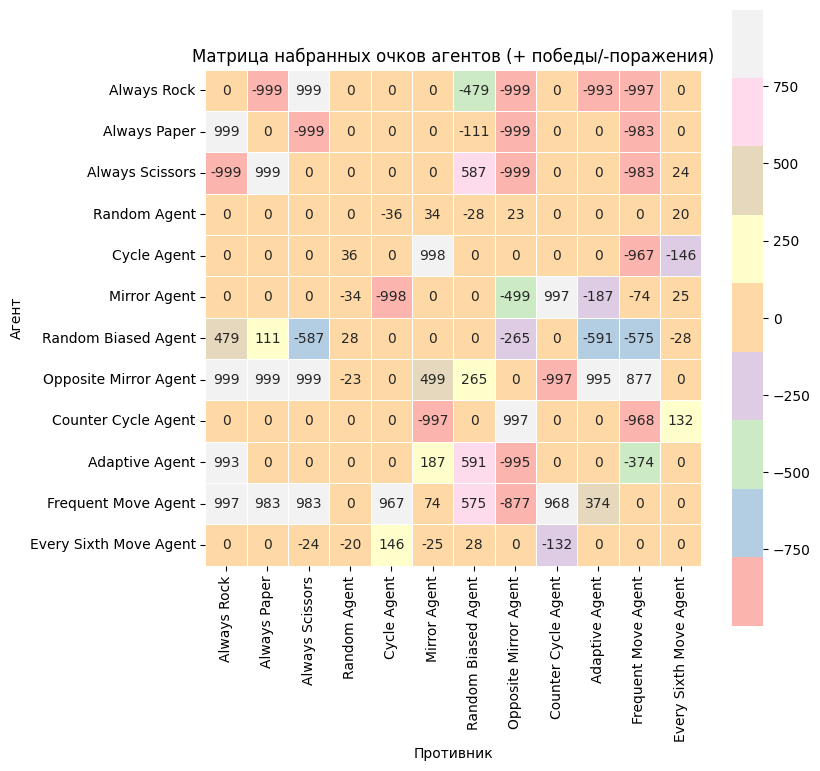

In [20]:
# Создаем DataFrame из матрицы
df = pd.DataFrame(wins_matrix, columns=[agent.name for agent in agents], index=[agent.name for agent in agents])

# Настройка размера графика
plt.figure(figsize=(8, 8))

# Создание тепловой карты
sns.heatmap(df, annot=True, fmt='g', cmap='Pastel1', cbar=True, square=True, linewidths=.5)

# Настройка заголовка и осей
plt.title('Матрица набранных очков агентов (+ победы/-поражения)')
plt.xlabel('Противник')
plt.ylabel('Агент')

plt.show()

In [21]:
# Выводим результаты турнира
# Сортируем результаты по очкам в порядке убывания
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
print("Турнирные результаты:")
for name, score in sorted_scores:
    print(f"{name}: {score}")

Турнирные результаты:
Frequent Move Agent: 5044.0
Opposite Mirror Agent: 4613.0
Adaptive Agent: 402.0
Random Agent: 13.0
Every Sixth Move Agent: -27.0
Cycle Agent: -79.0
Mirror Agent: -770.0
Counter Cycle Agent: -836.0
Always Scissors: -1371.0
Random Biased Agent: -1428.0
Always Paper: -2093.0
Always Rock: -3468.0


### Вывод: 
    
    Из представленных агентов победителем по набранным очкам стал Frequent Move Agent, сыграв по 1000 раз с каждым из 11 агентов. FrequentMoveAgent - анализирует статистику 30 ходов противника, выбирая противоположный победный ход.